In [9]:
import pandas as pd
import os

data_directory = "yellow_taxi_datasets"
csv_files = [f for f in os.listdir(data_directory) if f.endswith(".csv")]

df_list = [pd.read_csv(os.path.join(data_directory, f)) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Feature Engineering

In [10]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [11]:
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [12]:
df = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 180)]
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] < 100)]

In [13]:
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day'] = df['tpep_pickup_datetime'].dt.day
df['weekday'] = df['tpep_pickup_datetime'].dt.dayofweek
df['month'] = df['tpep_pickup_datetime'].dt.month
df['date'] = df['tpep_pickup_datetime'].dt.date

In [14]:
df.rename(columns={
    'pickup_latitude': 'pickup_lat',
    'pickup_longitude': 'pickup_lon',
    'dropoff_latitude': 'dropoff_lat',
    'dropoff_longitude': 'dropoff_lon'
}, inplace=True)

In [15]:
df.drop(columns=['RatecodeID'], inplace=True)

In [16]:
sample_df = df.sample(100_000).copy()

sample_df['log_duration'] = np.log1p(sample_df['trip_duration'])
sample_df['log_distance'] = np.log1p(sample_df['trip_distance'])

# Data Visualizations

## Trip Duration vs. Trip Distance

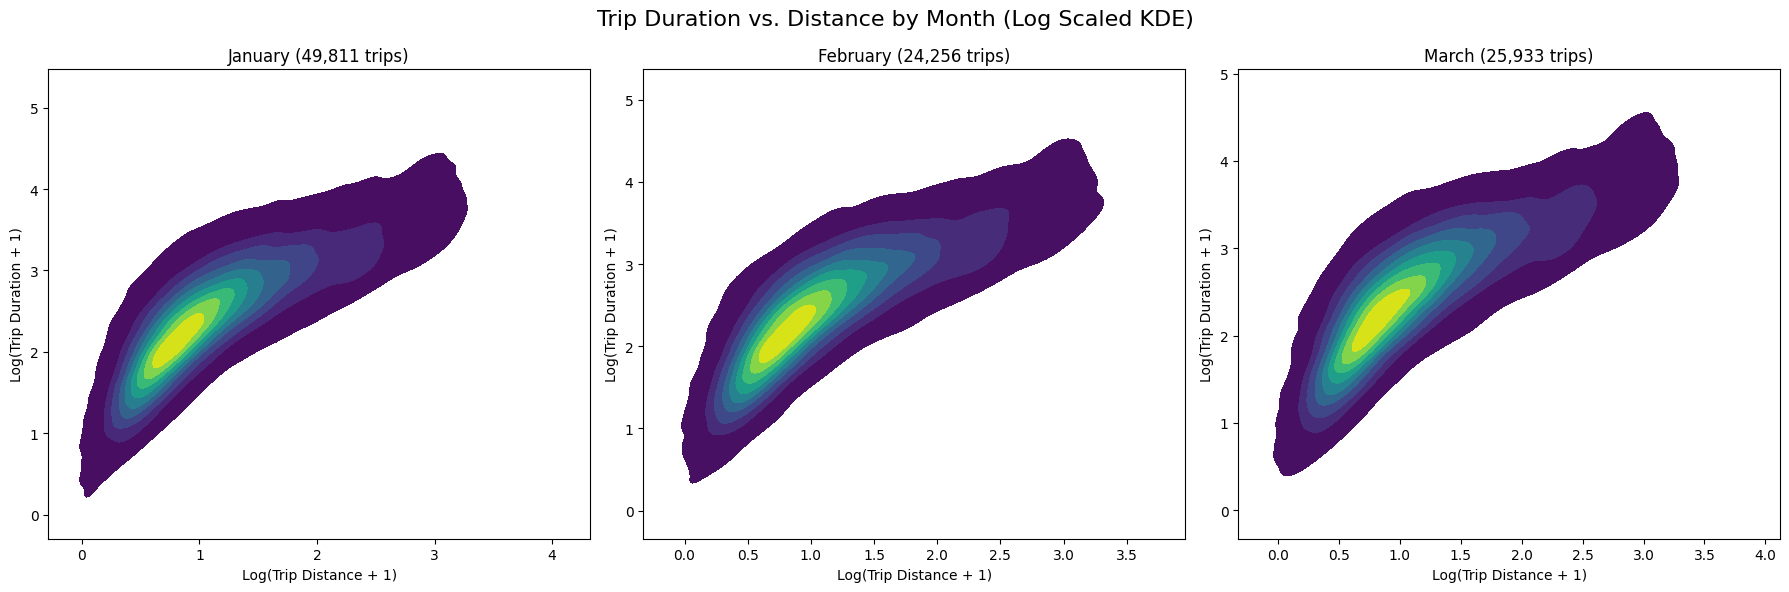

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

available_months = sorted(sample_df['month'].unique())
titles = {1: "January", 2: "February", 3: "March"}

fig, axes = plt.subplots(1, len(available_months), figsize=(6 * len(available_months), 6))

if len(available_months) == 1:
    axes = [axes]

for ax, month in zip(axes, available_months):
    month_df = sample_df[sample_df['month'] == month]
    sns.kdeplot(
        data=month_df,
        x="log_distance", y="log_duration",
        cmap="viridis", fill=True, thresh=0.01, ax=ax
    )
    ax.set_title(f"{titles.get(month, f'Month {month}')} ({len(month_df):,} trips)")
    ax.set_xlabel("Log(Trip Distance + 1)")
    ax.set_ylabel("Log(Trip Duration + 1)")

plt.suptitle("Trip Duration vs. Distance by Month (Log Scaled KDE)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## Trips by Hour of the Day

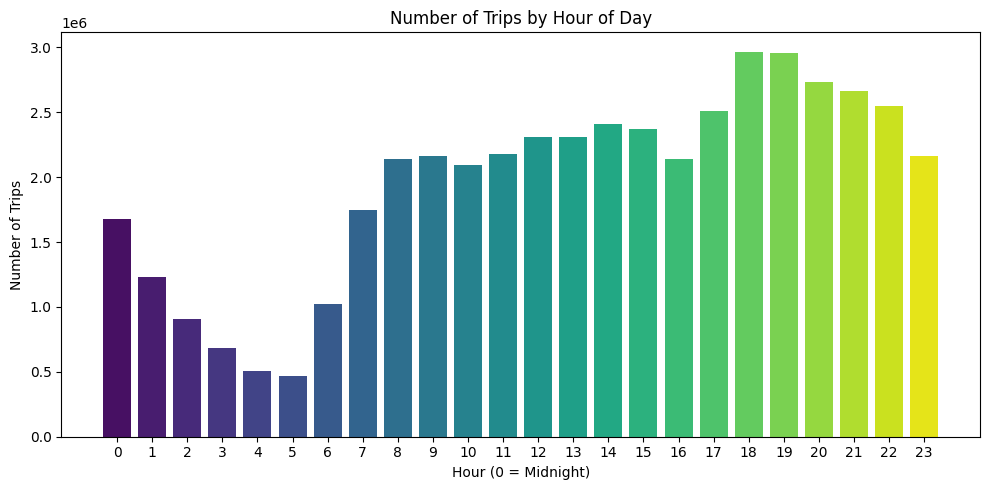

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

hour_counts = df['hour'].value_counts().sort_index()
colors = sns.color_palette("viridis", len(hour_counts))

plt.figure(figsize=(10, 5))
bars = plt.bar(hour_counts.index, hour_counts.values, color=colors)
plt.title('Number of Trips by Hour of Day')
plt.xlabel('Hour (0 = Midnight)')
plt.ylabel('Number of Trips')
plt.xticks(hour_counts.index)
plt.tight_layout()
plt.show()

## Trips by Day of the Week

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df['day_name'] = df['tpep_pickup_datetime'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='day_name', order=day_order, hue='day_name', palette='magma', legend=False)
plt.title('📅 Number of Trips by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

## Hour x Weekday Heatmap

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_data.index = [day_labels[d] for d in heatmap_data.index]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title("🔥 Heatmap of Taxi Trips by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()